In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


!pip install opencv-python-headless scikit-image matplotlib numpy

In [ ]:
#to unzip
import zipfile
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage import exposure, filters, morphology, util

# **Image Pre-processing code for LIVECELL**

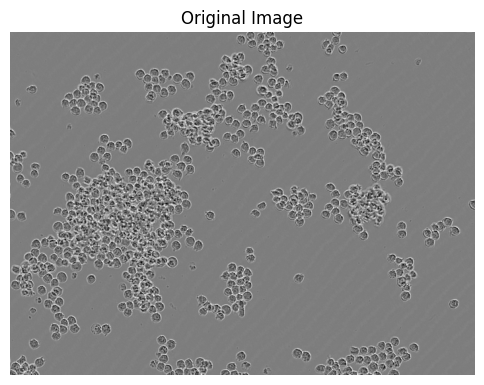

In [ ]:
# example image path (change this to your preprocessed image)
# img_path = "/content/drive/MyDrive/LIVECell_dataset_2021/images/livecell_train_val_images/A172/A172_Phase_A7_1_00d00h00m_1.png"
#img_path = "/content/drive/MyDrive/LIVECell_dataset_2021/images/livecell_train_val_images/BV2/BV2_Phase_D4_2_03d00h00m_3.tif"
#img_path = "/content/drive/MyDrive/LIVECell_dataset_2021/images/livecell_train_val_images/A172/A172_Phase_A7_2_00d00h00m_1.png"
#img_path = "/content/drive/MyDrive/LIVECell_dataset_2021/images/livecell_train_val_images/BV2/BV2_Phase_B4_1_03d00h00m_3.tif"
#img_path = "/content/drive/MyDrive/LIVECell_dataset_2021/images/livecell_train_val_images/BV2/BV2_Phase_B4_2_00d20h00m_3.tif"
#  img_path = "/content/drive/MyDrive/LIVECell_dataset_2021/images/livecell_train_val_images/BV2/BV2_Phase_B4_1_00d00h00m_3.tif"
img_path = "/content/drive/MyDrive/LIVECell_dataset_2021/images/livecell_train_val_images/BV2/BV2_Phase_B4_1_01d20h00m_3.tif"
# img_path = "/content/drive/MyDrive/LIVECell_dataset_2021/images/livecell_train_val_images/BV2/BV2_Phase_C4_2_01d20h00m_1.tif"
#img_path = "/content/drive/MyDrive/LIVECell_dataset_2021/images/livecell_train_val_images/BV2/BV2_Phase_B4_1_02d00h00m_1.tif"

# read the image in grayscale
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(6,6))
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.show()


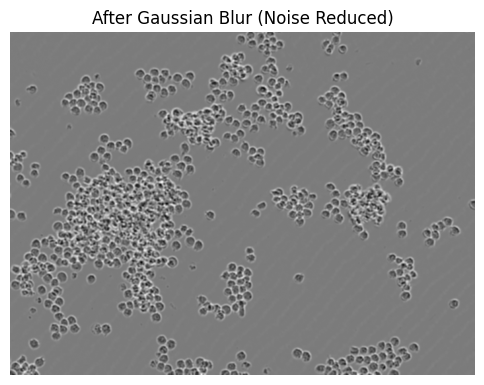

In [ ]:
# apply Gaussian Blur to smooth noise while keeping edges soft
blurred = cv2.GaussianBlur(img, (5,5), 0)

plt.figure(figsize=(6,6))
plt.imshow(blurred, cmap='gray')
plt.title("After Gaussian Blur (Noise Reduced)")
plt.axis('off')
plt.show()

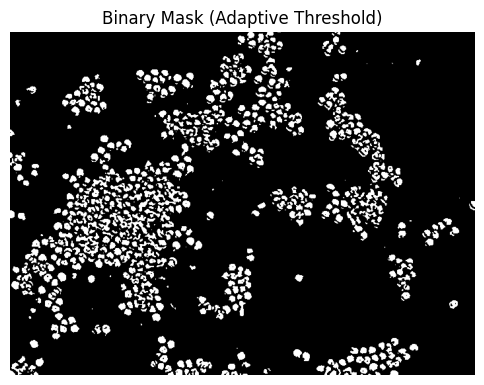

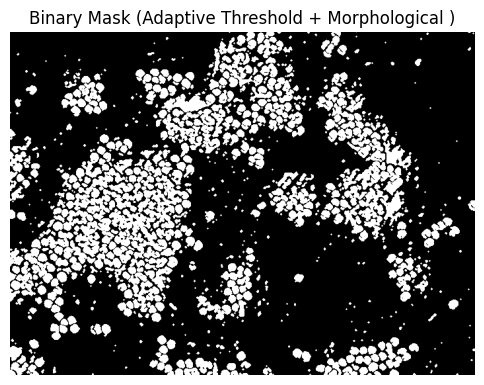

In [ ]:
# apply adaptive thresholding to separate foreground (cells) from background
thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                               cv2.THRESH_BINARY_INV, 71, 5)

plt.figure(figsize=(6,6))
plt.imshow(thresh, cmap='gray')
plt.title("Binary Mask (Adaptive Threshold)")
plt.axis('off')
plt.show()


# Adaptive Threshold + Morphological Correction
thresh = cv2.adaptiveThreshold(
    blurred, 255,
    cv2.ADAPTIVE_THRESH_MEAN_C,
    cv2.THRESH_BINARY_INV,
    49,    # increase window
    2      # decrease C (less shrinkage)
)

# Fix shrinkage → Expand cell boundaries
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
thresh_corrected = cv2.dilate(thresh, kernel, iterations=1)

plt.figure(figsize=(6,6))
plt.imshow(thresh_corrected, cmap='gray')
plt.title("Binary Mask (Adaptive Threshold + Morphological )")
plt.axis('off')
plt.show()

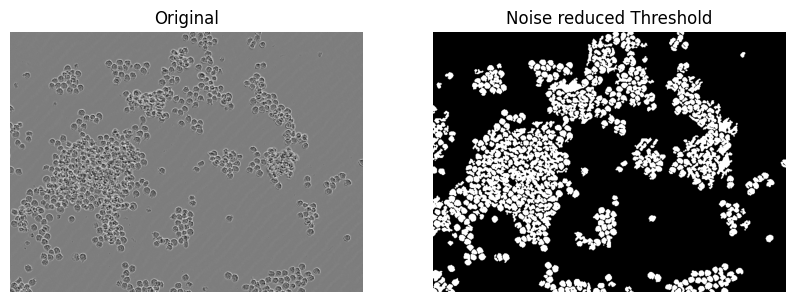

In [ ]:
# Find connected components
num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(thresh_corrected, connectivity=8)

# stats[:, cv2.CC_STAT_AREA] gives the size of each component
min_size = 70  # adjust

cleaned = np.zeros_like(thresh_corrected)
for i in range(1, num_labels):
    if stats[i, cv2.CC_STAT_AREA] >= min_size:
        cleaned[labels == i] = 255



plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title("Original")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cleaned, cmap='gray')
plt.title("Noise reduced Threshold")
plt.axis('off')

plt.show()


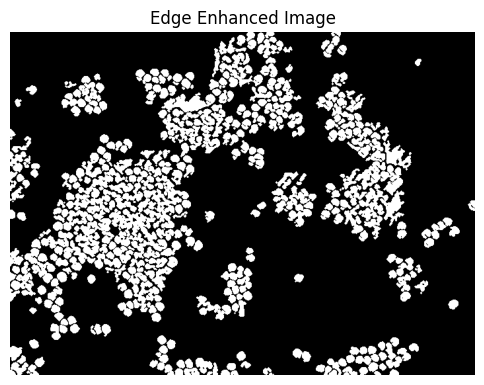

In [ ]:
# Apply Laplacian for edge enhancement
lap = cv2.Laplacian(cleaned, cv2.CV_64F)
lap = cv2.convertScaleAbs(lap)
edge_enhanced = cv2.addWeighted(cleaned, 1.5, lap, -0.5, 0)

plt.figure(figsize=(6,6))
plt.imshow(edge_enhanced, cmap='gray')
plt.title("Edge Enhanced Image")
plt.axis('off')
plt.show()

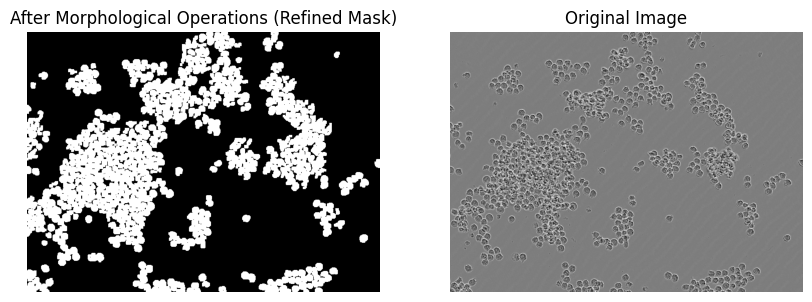

In [ ]:
# remove small noise and fill small holes
kernel = np.ones((3,3), np.uint8)
cleaned = cv2.morphologyEx(edge_enhanced, cv2.MORPH_OPEN, kernel, iterations=1)
cleaned = cv2.dilate(cleaned, kernel, iterations=1)


img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.imshow(cleaned, cmap='gray')
plt.title("After Morphological Operations (Refined Mask)")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.show()

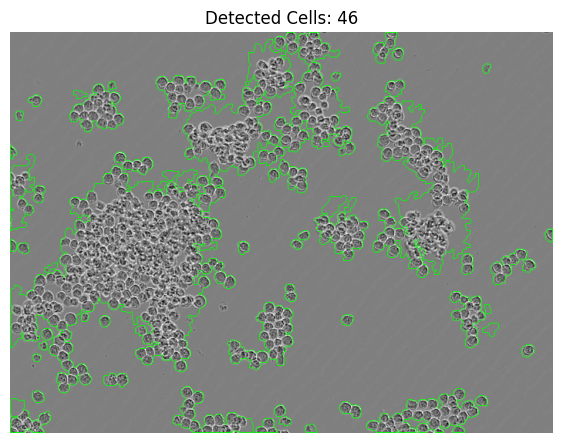

In [ ]:
# Find contours (boundaries of objects)
contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a color copy to visualize
output = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

# Draw only contours (no boxes or text)
valid_contours = []
for cnt in contours:
    area = cv2.contourArea(cnt)
    if area > 5:  # filter very small objects
        valid_contours.append(cnt)
        cv2.drawContours(output, [cnt], -1, (0,255,0), 1)  # green contour

# Count valid contours
cell_count = len(valid_contours)

# Display
plt.figure(figsize=(7,7))
plt.imshow(output)
plt.title(f"Detected Cells: {cell_count}")
plt.axis('off')
plt.show()



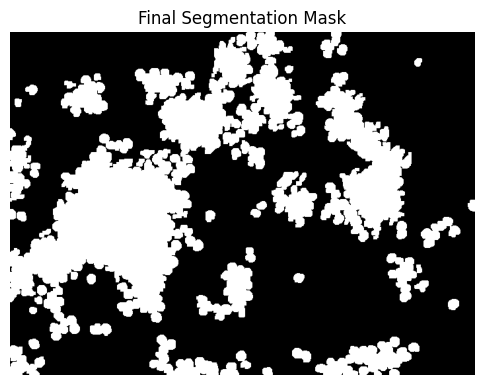

In [ ]:
# create blank mask to visualize segmentation
seg_mask = np.zeros_like(cleaned)

for cnt in contours:
    area = cv2.contourArea(cnt)
    if area > 1:
        cv2.drawContours(seg_mask, [cnt], -1, 255, -1)  # filled region

plt.figure(figsize=(6,6))
plt.imshow(seg_mask, cmap='gray')
plt.title("Final Segmentation Mask")
plt.axis('off')
plt.show()


Segmentation Performance Metrics:
Accuracy   : 86.94%
Precision  : 62.54%
Recall     : 95.19%
F1-score   : 75.49%
IoU (Jaccard): 60.62%
Dice Coefficient: 75.49%


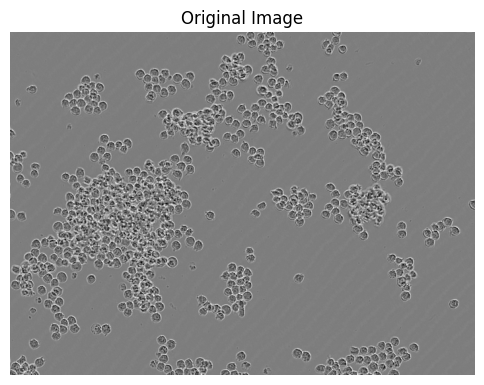

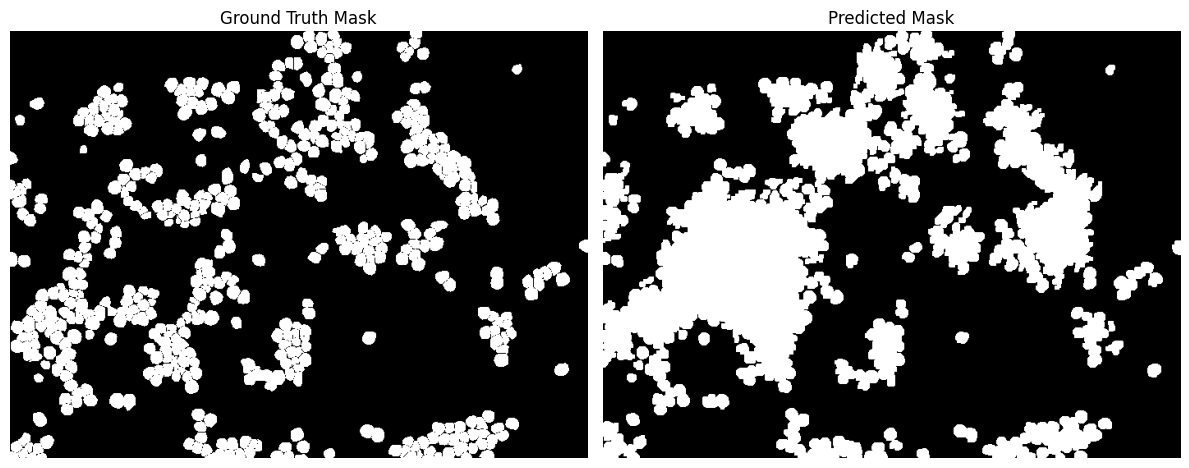

In [ ]:
# Accuracy


import cv2
import numpy as np
from sklearn.metrics import confusion_matrix

# --- Paths to your images ---
ground_truth_path = "/content/drive/MyDrive/DIP_Grp_5/LIVECell_dataset_2021/annotations/LIVECell/BV2_images/BV2_Phase_B4_1_01d20h00m_3.tif"
# predicted_path = "/path/to/predicted_mask.tif"

# --- Read images as grayscale ---
gt = cv2.imread(ground_truth_path, cv2.IMREAD_GRAYSCALE)
#pred = cv2.imread(predicted_path, cv2.IMREAD_GRAYSCALE)
pred = seg_mask

# --- Resize predicted if needed ---
if gt.shape != pred.shape:
    pred = cv2.resize(pred, (gt.shape[1], gt.shape[0]))

# --- Binarize both images (0 and 1) ---
_, gt_bin = cv2.threshold(gt, 127, 1, cv2.THRESH_BINARY)
_, pred_bin = cv2.threshold(pred, 127, 1, cv2.THRESH_BINARY)

# --- Flatten for metric calculation ---
gt_flat = gt_bin.flatten()
pred_flat = pred_bin.flatten()

# --- Confusion Matrix ---
tn, fp, fn, tp = confusion_matrix(gt_flat, pred_flat).ravel()

# --- Metrics ---
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp + 1e-8)
recall = tp / (tp + fn + 1e-8)
f1_score = 2 * precision * recall / (precision + recall + 1e-8)
iou = tp / (tp + fp + fn + 1e-8)
dice = (2 * tp) / (2 * tp + fp + fn + 1e-8)

print("Segmentation Performance Metrics:")
print(f"Accuracy   : {accuracy * 100:.2f}%")
print(f"Precision  : {precision * 100:.2f}%")
print(f"Recall     : {recall * 100:.2f}%")
print(f"F1-score   : {f1_score * 100:.2f}%")
print(f"IoU (Jaccard): {iou * 100:.2f}%")
print(f"Dice Coefficient: {dice * 100:.2f}%")


img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# plt.figure(figsize=(15, 5))

# # Original
# plt.subplot(1, 3, 1)
# plt.imshow(img, cmap='gray')
# plt.title("Original Image")
# plt.axis('off')

# # Ground Truth
# plt.subplot(1, 3, 2)
# plt.imshow(gt, cmap='gray')
# plt.title("Ground Truth Mask")
# plt.axis('off')

# # Predicted Result
# plt.subplot(1, 3, 3)
# plt.imshow(pred, cmap='gray')
# plt.title("Predicted Mask")
# plt.axis('off')

# # --- Display ---
# plt.tight_layout()
# plt.show()

# ---------------------------------------------
# Show Original Image Alone
# ---------------------------------------------
plt.figure(figsize=(6, 6))
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.show()

# ---------------------------------------------
# Show GT + Predicted Together
# ---------------------------------------------
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(gt, cmap='gray')
plt.title("Ground Truth Mask")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(pred, cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

plt.tight_layout()
plt.show()

